# Creating a General Purpose Potential for Molecular Crystals - Part 5

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- More tests...

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [3]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

### Compute necessary data and define SOAP

In [4]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [5]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Create learning curves for energy and force predictions

In [6]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [10]:
ntrain = 14000

In [22]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  256.2414925098419 s


In [23]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  899.6643948554993 s


In [24]:
dump_obj('raw_data/X_sparse_14k.json', X_sparse)

In [11]:
X_sparse = load_obj('raw_data/X_sparse_14k.json')

In [12]:
#Define kernel 
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
start=time()
Knm = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Knm[:nstructs] has the energy row of each structure 

Knm[nstructs:] has the force rows of each structure, which is organised as follows:
- There are natoms * 3 rows per structure
- Organised in the order of structures in nstruct
- i.e., to extract the force rows for structure with index 0, you have to figure out the number of atoms in that structure (e.g. 40), and multiply by 3, and then extract those indices from the end of the energy rows for all structures (as this is the structure with index 0). I.e. : Knm[nstruct:(nstruct+(40*3))]

In [ ]:
np.save('raw_data/Knm_kernel_14k', Knm)
print("KNM saved")

In [14]:
Knm = np.load('raw_data/Knm_kernel_14k.npy')

In [13]:
#make list of number of atoms in each structure
nat_per_struct=[]
for frm in train_set_FPS[:ntrain]:
    nat_per_struct.append(len(frm))

In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm, X_sparse, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
np.save('results_data/yval_pred_14k', yval_pred)
np.save('results_data/fval_pred_14k', fval_pred)

In [13]:
npred=1000
yval_pred = np.load('results_data/yval_pred_14k.npy')
fval_pred = np.load('results_data/fval_pred_14k.npy')

In [14]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [17]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [18]:
print('RMSE energy:', rmse_energy, 'eV/atom')
print('RMSE forces:', rmse_forces, 'eV/angstrom')

RMSE energy: 0.005445800449245529 eV/atom
RMSE forces: 0.38404849064855484 eV/angstrom


In [15]:
for i in range(1000,15000,1000):
    print('Creating model using', i, 'training structures...')
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Kernelnm = np.zeros((i+nforce_rows, Knm.shape[1]))
    print('Computing kernel...')
    Kernelnm[:i] = Knm[:i]
    Kernelnm[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    print('Creating model...')
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_lc_'+str(i), yval_pred)
    np.save('results_data/fval_pred_lc_'+str(i), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")

Creating model using 1000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.018605185747567955 eV/atom
RMSE forces: 0.374288145112019 eV/angstrom

Creating model using 2000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.010180187480841303 eV/atom
RMSE forces: 0.38900621538794705 eV/angstrom

Creating model using 3000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.007117896428504622 eV/atom
RMSE forces: 0.39074154333210837 eV/angstrom

Creating model using 4000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.006650503363529594 eV/atom
RMSE forces: 0.38974427987493065 eV/angstrom

Creating model using 5000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.00637998814212301 eV/atom
RMSE forces: 0.3908333615365183 eV/angstrom

Creating model using 6000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.006217729178197441 eV/atom
RMSE forces: 0.3873547382079486 eV/angstrom

Creating model using 7000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005969171250072053 eV/atom
RMSE forces: 0.38626271700082665 eV/angstrom

Creating model using 8000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.00577435914483878 eV/atom
RMSE forces: 0.38546857390970407 eV/angstrom

Creating model using 9000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.0056725263823453834 eV/atom
RMSE forces: 0.3839886377315317 eV/angstrom

Creating model using 10000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005573389811260722 eV/atom
RMSE forces: 0.3814997985532318 eV/angstrom

Creating model using 11000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005525750486718551 eV/atom
RMSE forces: 0.382403325089767 eV/angstrom

Creating model using 12000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005465802088514222 eV/atom
RMSE forces: 0.3828256188916966 eV/angstrom

Creating model using 13000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005443024140781266 eV/atom
RMSE forces: 0.3815627201129578 eV/angstrom

Creating model using 14000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005445800449234075 eV/atom
RMSE forces: 0.3840484906479948 eV/angstrom



### Create small models to optimise force reg

In [16]:
for ffreg in np.logspace(-4, 2, 7):
    i=10000
    freg = ffreg*5.5
    print('Creating model using a force regulariser of', freg)
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Kernelnm = np.zeros((i+nforce_rows, Knm.shape[1]))
    Kernelnm[:i] = Knm[:i]
    Kernelnm[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[0.055,freg], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_freg_'+str(freg), yval_pred)
    np.save('results_data/fval_pred_freg_'+str(freg), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")

Creating model using a force regulariser of 0.00055


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.7557947487067933 eV/atom
RMSE forces: 0.32073228009210447 eV/angstrom

Creating model using a force regulariser of 0.0055


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.09248910460895907 eV/atom
RMSE forces: 0.32107376001136084 eV/angstrom

Creating model using a force regulariser of 0.055


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.043119946500418206 eV/atom
RMSE forces: 0.32256777873883097 eV/angstrom

Creating model using a force regulariser of 0.55


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.014746990931449225 eV/atom
RMSE forces: 0.33897861679462654 eV/angstrom

Creating model using a force regulariser of 5.5


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005055361457157153 eV/atom
RMSE forces: 0.4010042586177946 eV/angstrom

Creating model using a force regulariser of 55.0


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.00520497468025711 eV/atom
RMSE forces: 0.6368299580584922 eV/angstrom

Creating model using a force regulariser of 550.0


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005337667322883139 eV/atom
RMSE forces: 0.7063588617995449 eV/angstrom



## Create model using one crystal

In [4]:
#Load database of 100 MD + geop structure
dictionary_file = open("raw_data/CSD-10k_combined_w_kpts.pickle", "rb") #open saved pickle database
db = pickle.load(dictionary_file)
name=list(db.keys())

In [81]:
#Choose single crystal
crystal = db['TOQMUH01']
for frm in crystal:
    frm.wrap()

In [83]:
crystal_feats = get_features(crystal)

  0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
greedysel = FPS(n_to_select = 100)
greedyfeats = greedysel.fit(crystal_feats)

In [85]:
greedyids = []
for gfeats in greedyfeats.X_selected_:
    for icfeats, cfeats in enumerate(crystal_feats):
        if np.array_equal(cfeats, gfeats):
            greedyids.append(icfeats)

In [102]:
ntrain = 90
ntest = 10
crystal_train = [crystal[i] for i in greedyids[:ntrain]]
crystal_test = [crystal[i] for i in greedyids[ntrain:ntrain+ntest]]

In [105]:
#get training and test data
y_train_cryst = []
X_train_cryst = np.zeros((len(crystal_train),4), dtype=int)
for ifrm, frm in enumerate(crystal_train):
    y_train_cryst.append(frm.info['energy'])
    symbols=frm.get_atomic_numbers()
    X_train_cryst[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

y_test_cryst = []
forces_test = []
X_test_cryst = np.zeros((len(crystal_test),4), dtype=int)
for ifrm, frm in enumerate(crystal_test):
    y_test_cryst.append(frm.info['energy'])
    symbols=frm.get_atomic_numbers()
    X_test_cryst[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    forces_test.append(frm.get_array('forces'))
ftest = np.concatenate(forces_test)
    
y_all = []
X_all = np.zeros((len(crystal),4), dtype=int)
for ifrm, frm in enumerate(crystal):
    y_all.append(frm.info['energy'])
    symbols=frm.get_atomic_numbers()
    X_all[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

In [95]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(crystal_train) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  3.5424845218658447 s


In [96]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1250
nc = 1250
nn = 1250
no = 1250
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
The number of pseudo points selected by central atom species is: {1: 1250, 6: 1250, 7: 1250, 8: 1250}
Selecting species: 1
Selecting species: 6
Selecting species: 7
Selecting species: 8
Time taken:  61.74083089828491 s


In [98]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [99]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(crystal_train, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/90 [00:00<?, ?it/s]

Time taken:  1983.9187462329865 s


In [106]:
#created dressed atom energies model
mlrc = Ridge(alpha=1E-4, fit_intercept=False) #Don't fit intercept
mlrc.fit(X_all, y_all)
print("Intercept: ", mlrc.intercept_)
print("Coefficients:", mlrc.coef_)
y_dressed_cryst = mlrc.coef_

Intercept:  0.0
Coefficients: [-248.96613279 -248.96606276 -149.3794511   -99.58649579]


In [109]:
y_train_cryst = np.asarray(y_train_cryst)

In [112]:
y_dressed_cryst = {}
for ii, i in enumerate([1,6,7,8]):
    y_dressed_cryst[i] = mlrc.coef_[ii]
print(y_dressed_cryst)

{1: -248.96613279388754, 6: -248.96606275900504, 7: -149.37945109932093, 8: -99.58649579209921}


In [119]:
#Train GAP model
print("Training GAP model...")
start = time()
model = train_gap_model(kernel, crystal_train, Knm, X_sparse, y_train_cryst, y_dressed_cryst, 
                        grad_train=-get_forces(crystal_train), lambdas=[0.01,0.1], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 14.113807678222656


In [120]:
#predict energies and forces for validation set
npred=10
ytp = []
ftp = []

for ifrm, frm in enumerate(tqdm(crystal_test[:npred], desc = "Making predictions for test set...", leave=False)):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
    ftp.append(model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for test set...:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

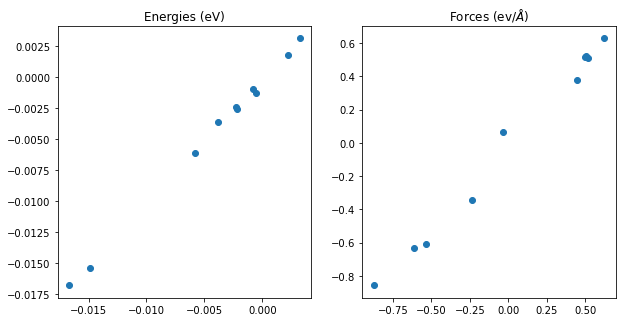

In [121]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_test_cryst[:npred] - mlrc.predict(X_test_cryst[:npred]))/np.sum(X_test_cryst[:npred],axis=1),
             (ytest_pred[:npred] - mlrc.predict(X_test_cryst[:npred]))/np.sum(X_test_cryst[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(ftest.flatten()[:npred], ftest_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [122]:
rmse_energy = np.sqrt(np.mean(((y_test_cryst[:npred] - mlrc.predict(X_test_cryst[:npred]))/np.sum(X_test_cryst[:npred],axis=1) - (ytest_pred[:npred] - mlrc.predict(X_test_cryst[:npred]))/np.sum(X_test_cryst[:npred],axis=1))**2))

In [123]:
rmse_forces = np.sqrt(np.mean((ftest.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [124]:
print(rmse_energy, rmse_forces)

0.00035620323059686856 0.05799289121406542


RMSEs can get very low using a single crystal. Maybe try and re-optimise energy and force regs and check errors...

## Optimise regularisers using ntrain = 14000

In [6]:
X_sparse = load_obj('raw_data/X_sparse_14k.json')

In [67]:
#Define kernel 
hypers["compute_gradients"] = True
hypers["max_radial"] = 6
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [8]:
Knm = np.load('raw_data/Knm_kernel_14k.npy')

In [73]:
ntrain=14000

In [74]:
#make list of number of atoms in each structure
nat_per_struct=[]
for frm in train_set_FPS[:ntrain]:
    nat_per_struct.append(len(frm))

In [ ]:
for freg in np.logspace(-3, 1, 5):
    i=14000
    ereg = freg/10
    print('Creating model using energy and force regularisers of', ereg, 'and', freg, ', respectively.')
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Kernelnm = np.zeros((i+nforce_rows, Knm.shape[1]))
    Kernelnm[:i] = Knm[:i]
    Kernelnm[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[ereg,freg], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_14k_regs_'+str(ereg)+'_'+str(freg), yval_pred)
    np.save('results_data/fval_pred_14k_regs_'+str(ereg)+'_'+str(freg), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")

Creating model using energy and force regularisers of 0.0001 and 0.001 , respectively.


In [28]:
#(Re-)load predictions
i=0
for freg in np.logspace(-3, 1, 5):
    ereg = freg/10
    exec('fval_reg_'+str(i)+'=np.load("results_data/fval_pred_14k_regs_'+str(ereg)+'_'+str(freg)+'.npy")')
    exec('yval_reg_'+str(i)+'=np.load("results_data/yval_pred_14k_regs_'+str(ereg)+'_'+str(freg)+'.npy")')
    i+=1

In [36]:
#print results
j = 0.001
for i in range(0,5):
    fval_pred=eval('fval_reg_'+str(i))
    yval_pred=eval('yval_reg_'+str(i))
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print("Errors using a force reg of", j, "and an energy reg of", j/10, ":",rmse_energy, rmse_forces)
    j*=10

Errors using a force reg of 0.001 and an energy reg of 0.0001 : 0.014855182310613278 0.3420058979320686
Errors using a force reg of 0.01 and an energy reg of 0.001 : 0.014855183576198304 0.34200589204058174
Errors using a force reg of 0.1 and an energy reg of 0.01 : 0.01485531015498886 0.3420053039357186
Errors using a force reg of 1.0 and an energy reg of 0.1 : 0.01486817493588458 0.3419566287633549
Errors using a force reg of 10.0 and an energy reg of 1.0 : 0.015999834953778307 0.3486655634818374


## Test using a radial cutoff of 4 angstrom

In [44]:
ntrain = 8400

In [45]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [46]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  45.94664263725281 s


In [47]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
The number of pseudo points selected by central atom species is: {1: 1778, 6: 1467, 7: 1467, 8: 1778}
Selecting species: 1
Selecting species: 6
Selecting species: 7
Selecting species: 8
Time taken:  1519.6918544769287 s


In [48]:
dump_obj('raw_data/X_sparse_cutoff_4.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_cutoff_4.json')

In [49]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [50]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Time taken:  32585.88679265976 s


In [51]:
#Save kernel
np.save('raw_data/Knm_kernel_cutoff_4', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_cutoff_4.npy')

In [52]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 510.42740416526794


In [53]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

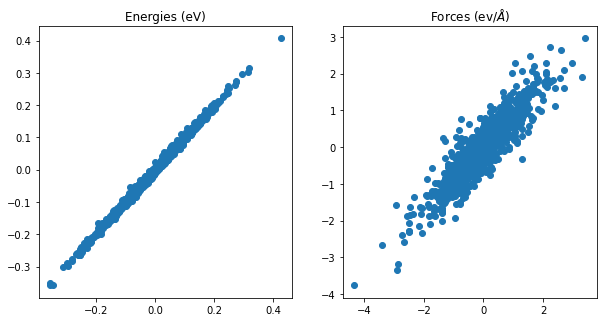

In [54]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [55]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [56]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [57]:
print(rmse_energy, rmse_forces)

0.0068695332078848 0.38428536425585297


In [58]:
np.savetxt('results_data/cutoff_4A_results.txt', np.array([rmse_energy, rmse_forces]))

## Create 20k model with nmax = 6, lmax = 4, rc = 4, nsparse = 2500

In [6]:
ntrain = 20000

In [7]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [8]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  124.54603552818298 s


In [9]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2500
nc = 2500
nn = 2500
no = 2500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
The number of pseudo points selected by central atom species is: {1: 2500, 6: 2500, 7: 2500, 8: 2500}
Selecting species: 1
Selecting species: 6
Selecting species: 7
Selecting species: 8
Time taken:  6465.67889714241 s


In [10]:
dump_obj('raw_data/X_sparse_20k.json', X_sparse_FPS)

In [11]:
X_sparse_FPS = load_obj('raw_data/X_sparse_20k.json')

In [12]:
X_sparse_FPS.get_features().shape

(10000, 1800)

In [8]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [12]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/20000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Time taken:  167826.75932455063 s


In [13]:
#Save kernel
np.save('raw_data/Knm_kernel_20k_2500ns', Knm_FPS)

In [15]:
start = time()
print("Loading Knm...")
Knm_FPS = np.load('raw_data/Knm_kernel_20k_2500ns.npy')
print("Knm loading time:", time()-start)

Loading Knm...
Knm loading time: 1779.0270457267761


In [31]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], 
                             y_dressed, grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.01,0.1], 
                             jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 1047.8662610054016


In [32]:
#Save model
dump_obj('model_data/full_GAP_model_20k_2500ps_0.01_0.1.json', full_model)

In [9]:
#Reload model
full_model = load_obj('model_data/full_GAP_model_20k_2500ps_0.01_0.1.json')

In [10]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
specs = []
for frm in val_set:
    specs.append(frm.get_atomic_numbers())
fval_spec = np.asarray(specs)

In [31]:
hs = []
cs = []
ns = []
os = []
for ispec, spec in enumerate(fval_spec):
    if spec == 1:
        hs.append(ispec)
    if spec == 6:
        cs.append(ispec)
    if spec == 7:
        ns.append(ispec)
    if spec == 8:
        os.append(ispec)

In [46]:
force_true = []
force_pred = []
for no in os:
    force_true.append(fval_true[no])
    force_pred.append(fval_pred[no])
force_true = np.asarray(force_true)
force_pred = np.asarray(force_pred)
rmse = np.sqrt(np.mean((force_true.flatten() - force_pred.flatten())**2))
print("Force RMSE for o atoms:", rmse)

Force RMSE for o atoms: 0.272729554146489


Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

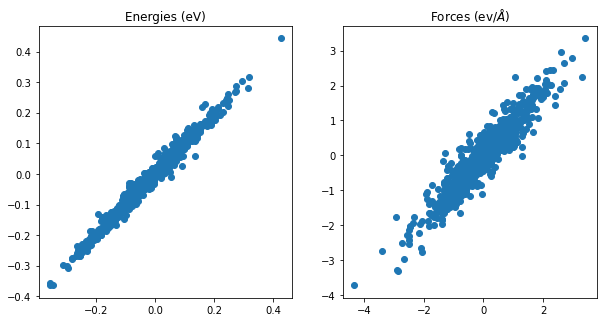

In [11]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [12]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [13]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten() - fval_pred.flatten())**2))

In [14]:
print(rmse_energy, rmse_forces)

0.014955712241455683 0.2851721312075109


In [28]:
energies_err_pa = (yval_true - yval_pred)/np.sum(X_val[:npred], axis=1)

In [38]:
# Calculate stddev of energy and force predictions
print("Std. dev. of energies (per atom)", np.std((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1)))
print("Std. dev. of energies errors (per atom) =", np.std(energies_err_pa))
print("Std. dev. of forces =", np.std(fval_pred.flatten()), flush = True)

Std. dev. of energies (per atom) 0.10627934719393947
Std. dev. of energies errors (per atom) = 0.014939804544765217
Std. dev. of forces = 0.7899469555178046


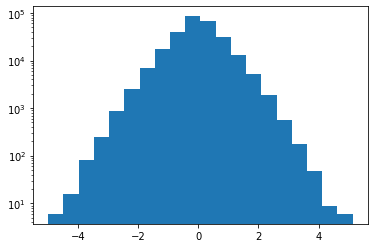

In [42]:
#Distribution of the force predictions
plt.hist(fval_pred.flatten(), bins=20)
plt.yscale('log')

In [47]:
mae_pred = np.mean(np.absolute(fval_pred.flatten() - fval_true.flatten()))
print("Mean absolute error of force predictions:", mae_pred)

Mean absolute error of force predictions: 0.19863162404848117


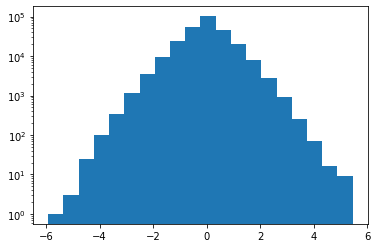

In [51]:
#Distribution of the true forces
plt.hist(fval_true.flatten(), bins=20)
plt.yscale('log')

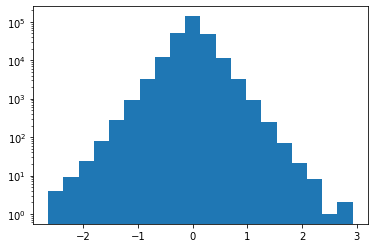

In [50]:
#Distribution of the errors in force predictions
plt.hist(fval_true.flatten()-fval_pred.flatten(), bins=20)
plt.yscale('log')

In [22]:
np.savetxt('results_data/20k_2500ns_0.01_0.1_results.txt', np.array([rmse_energy, rmse_forces]))

In [ ]:
#Train GAP model using 0.01 for both energy and force regularizers
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.01,0.01], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [24]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

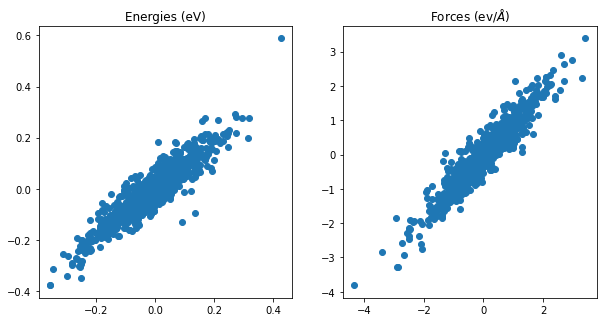

In [25]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [26]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [27]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [28]:
print(rmse_energy, rmse_forces)

0.04097007221841042 0.2972992726738704


In [29]:
np.savetxt('results_data/20k_2500ns_0.01_0.01_results.txt', np.array([rmse_energy, rmse_forces]))